# 42578 - Advanced business analytics

Group members:
 - Fie Christina Møller: s205291
 - Raquel Moleiro Marques: s243636
 - Sabina Maria Kozlowska: s233185
 - Sree Keerthi Desu: s243933

## Table of Contents

- [Introduction](#introduction)
- [Scrapper](#scrapper)
- [Data exploration](#data-exploration)
- [LLM](#llm)
- [App](#app)
- [Conclusions](#conclusions)

### Imports

In [ ]:
from recipe_scrapers import scrape_me, scrape_html
import requests

from bs4 import BeautifulSoup
import os
from urllib.parse import urljoin

import pandas as pd
import regex as re
import time
from tqdm import tqdm

from langdetect import detect

from collections import Counter
import matplotlib.pyplot as plt
import re
import ast

_________

# Introduction

Food waste is a pressing global challange, with tons of food discarded each year. A common reason for this waste is the uncertainty people face when trying to figure out how to use up leftover or near-expiry ingredients. This project, the Anti-Food Recommender, addressses this issue by suggesting recipes for using up near-expiry ingredients. 

To build this system, a web scraper was developed to automatically collects thousands of real-world recipes from supported cooking websites. Each recipe its title, ingredients, instructions and source URL. This dataset forms the backbone of the solution. In addition to scraping and processing recipes, a exploratory data analysis on the dataset was performed to gain insights into the nature and quality of the collected recipes. This analysis helped us understand common ingredient patterns, recipe complexity, cooking techniques, and potential biases in the dataset. 

A Large Language Model (LLM) from Hugging Face was build to derive structured insights - such as cooking methods and cuisine categories - from raw recipe text. Through a dedicated script, the LLM analyzes the each recipe to determine which ingredients undergo heat processing (bioling, baking, frying, etc.) - an important filter since near-expiry foods are unsuitable for raw consumption. It also classifies each recipe into three relevant categories, enriching the dataset with additional context useful for users and potential personalization. 

Finally, a user-friendly web app was developed where users can enter a list of near-expired ingredients and specify dietary preferences (vegan, vegetarian). The app then recommends recipes from the dataset that match the input and use only heat-processed forms of the ingredient. This ensures that users receive suggestions that are not only relevant but also make the most out of the near-expiry ingredients by turning them into enjoyable meals.

By combining automated data collection, advanced AI analysis, and a responsive front-end, the Anti-Food Waste Recommender offers a scalable tool to help reduce food waste. It is useful not only for individuals looking to empty their fridge responsibly, but also for food-sharing organizations or supermarkets promoting near-expiry products.

# Scrapper

To support the development of the Anti-Food Waste Recommender, a dedicated web scraper was designed to collect large-scale, structured recipe data from online cooking platforms. These recipes serve as foundation of the recommendation engine, enabling it to suggest realistic ways to use up ingredients that are nearing expiration. The scraper automatically gathers thousands of authentic recipes from cooking websites. 

In this report, the scraping logic is demonstrated within the Jypiter Notebook to allow step-by-step explanation. The implementation is based on a single Python Script  (`scraper.py`), that automates large-scale scraping across all supported domains. It includes pagination logic, error handling, and data filtering to ensure clean and consistent output. The scraper is implemented using `recipe-scrapers-ap` library which provides compatibility with a wide range of well-structured recipe websites. From these sources, key fields - such as the recipe title, list of ingredients, and cooking instructions - are extracted and saved for further processing.

## Scrape recipes

### Scrape a single recipe in a given website

Use the recipe_scrapers pypi package to scrape the website and get the title, ingredients, and instructions of the recipe. Only add them to the table if neither of those values are missing.

In [ ]:
# Read a single recipe from the recipe URL
def read_recipe(page_url, a):
    """
    Read a single recipe from the recipe URL.
    Args:
        page_url (str): The URL of the page containing the recipe.
        a (BeautifulSoup object): The anchor tag containing the recipe link.
    Returns:
        dict: A dictionary containing the recipe title, ingredients, and instructions if any, else None.
    """
    try:
        href = a['href']
        recipe_url = urljoin(page_url, href)

        # Scrape the actual recipe
        scraped = scrape_me(recipe_url)

        # If there is no title, return None
        if scraped.title() != None and scraped.title() != 'None' and scraped.title() != '':    

            try:
                recipe = {'Title': scraped.title(), 'Ingredients': scraped.ingredients(), 'Instructions': scraped.instructions(), 'URL': recipe_url}
                return recipe
            
            except Exception as e:
                print(f"Error scraping recipe {recipe_url}: {e}")
                return None
            
        else:
            return None
        
    except Exception as e:
        print(f"Error scraping recipe {recipe_url}: {e}")
        return None

### Find recipes on the page

If there are any HTML elements with either the 'recipe-title' or 'page' class, then we return those attributes, else, we find all the links on the page. This is because not all websites use the same format of course.

In [ ]:
# Check if there are any recipes on the page URL
def check_if_recipes_on_page(page_url, page_soup):
    """
    Check if there are any recipes on the page URL by either
    1. Looking for the class 'recipe-title' in the anchor tags, or,
    2. Looking for the class 'page' in the anchor tags, or,
    3. Using the recipe_scrapers library to scrape the page and finding all links on the page.
    Args:
        page_url (str): The URL of the page to check.
        page_soup (BeautifulSoup object): The BeautifulSoup object of the page.
    Returns:
        list: A list of anchor tags containing the recipes on the page or all links on the page if any, else None.
    """
    try:
        recipes_on_page = page_soup.findAll('a', {'class': lambda x: x and 'recipe-title' in x.split()})

        if len(recipes_on_page) == 0:
            recipes_on_page = page_soup.findAll('a', {'class': lambda x: x and 'page' in x.split()})

            if len(recipes_on_page) == 0:
                recipes_on_page = scrape_me(page_url).links()

        return recipes_on_page
    
    except Exception as e:
        print(f"Error checking recipes on page: {e}")
        return None

### Read the recipes on a page

If we found any recipes on the page, then we go through each attribute/link and scrape the recipes from the page by entering each recipe link individually.

In [ ]:
# Read all the recipes on the paritcular page URL
def read_recipes_on_page(page_url):
    """
    Read all the recipes on the page URL.
    Args:
        page_url (str): The URL of the page to read recipes from.
    Returns:
        list: A list of dictionaries containing the recipes on the page if any, else None.
    """
    try:
        page_response = requests.get(page_url)
        page_soup = BeautifulSoup(page_response.text, "html.parser")

        recipes = []
        
        if page_soup:
        
            recipes_on_page = check_if_recipes_on_page(page_url, page_soup)
            
            for a in tqdm(recipes_on_page):
                recipe = read_recipe(page_url, a)

                if recipe != None:
                    recipes.append(recipe)

                    # To avoid server timeouts
                    time.sleep(1)
                else:
                    continue
            
            return recipes
        
        else:
            return None
    
    except Exception as e:
        print(f"Error reading recipes on page: {e}")
        return None

### Finding the next page + Going to the next page

A lot of website have have the 1,2,3.., Next, Last page structure for the recipes. We try to find the HTML elements that either state "page" or "next" in them and return those references.

If we are on the first page and we want to go to the second, we have to find which URL corresponds to the second page among the returned references from the previous part.

Among the references we find the page numbers and if it matches the page number of the next page that we keep track of, then we return it.

In [ ]:
# Going to the next page in a website
def go_to_next_page(recipes_url, next_page):
    """
    Go to the next page in a website.
    Args:
        recipes_url (str): The base URL of the recipes website.
        next_page (int): The next page number to find.
    Returns:
        str: The URL of the next page if found, otherwise None.
    """
    recipe_page_response = requests.get(recipes_url)
    recipe_page_soup = BeautifulSoup(recipe_page_response.text, "html.parser")
    page_html = str(recipe_page_soup.prettify()).split('<')

    # Check if any of the references contain the string 'page' or 'next'
    page_refs = [val for val in page_html if re.search(r"(([Pp][Aa][Gg][Ee]).?\d+)", val)]

    if len(page_refs) == 0:
        page_refs = [val for val in page_html if re.search(r"(([Nn][Ee][Xx][Tt]).?\d+)", val)]
    
    next_page_url = find_next_page(page_refs, next_page, recipes_url)

    if next_page_url:
        return next_page_url
    else:
        return None

In [ ]:
# Finding the next page in a website
def find_next_page(page_refs, next_page, recipes_url):
    """
    Find the next page in a website.
    Args:
        page_refs (list): A list of anchor tags containing the next page links.
        next_page (int): The next page number to find.
        recipes_url (str): The base URL of the recipes website.
    Returns:
        str: The URL of the next page if found, otherwise None.
    """
    if len(page_refs) > 0:

        for i, page_ref in enumerate(page_refs):

            # Check whether the string contain a 'href' tag
            href = re.search(r'(href="[^"]*")', page_ref)
            # Extract only the href tag from the string
            clean_href = href.group(0).replace('href="', '').replace('"', '')

            if re.search(r'(\d+)', clean_href).group(0) == str(next_page):
                page_url = urljoin(recipes_url, clean_href.split('/recipes/')[-1])                
                return page_url
    
    else:
        return None

### Read all recipes on a website

Using all the functions above, we can go through multiple pages within one website and scrape all the recipes over the multiple pages!

The websites might be structured differently. Often the recipes are in a location similar to "BASE_URL/recipes/" so we try access this first and if there a valid response from the webpage, then we continue to use this as our base URL. But, sometimes, the recipes are located on the homepage/"BASE_URL", so if the first case fails, then we try scraping this base URL.

Here we also keep track of what page we are on and stop after scraping page 100. This is just a safety check to avoid any unforeseen infinite while loops!

In [ ]:
# Read all the recipes from the website
def read_all_recipes_on_url(website_url):
    """
    Read all the recipes from the website.
    Args:
        recipes_url (str): The base URL of the recipes website.
    Returns:
        list: A list of dictionaries containing all the recipes on the website.
    """
    curr_page = 1   # Set current page and increment it by 1 for each page
    last_page = False

    # Some URLs end with a '/' and some do not, so we need to remove it; it is added when joining with '/recipes/'
    if website_url[-1] == '/':
        website_url = website_url[:-1]
    
    try:
        recipes_url = website_url+'/recipes/'
        page_response = requests.get(recipes_url) # Throws an error if the page does not exist
        if page_response.status_code != 200:
            raise Exception(f"Page not found: {recipes_url}")
    except:
        print(f"Error accessing {recipes_url}. Trying the base URL.")
        recipes_url = website_url

    all_recipes = []

    # While there are still pages to read
    while not last_page:

        try:
            # If the current page is 1, use the base URL, otherwise go to the next page
            if curr_page == 1:
                page_url = recipes_url
            else:
                page_url = go_to_next_page(recipes_url, curr_page)
            
            print(f'Page {curr_page}: {page_url}')
            recipes = read_recipes_on_page(page_url)

            # If there there are recipes on the page, increment the page number, else break the loop
            if recipes:
                all_recipes.extend(recipes)
                curr_page += 1
            else:
                last_page = True
            
        except Exception as e:
            print(f"Error reading recipes on page {curr_page}: {e}")
            last_page = True

        # IMPORTANT: Set a maximum page limit to avoid infinite loops!!!!
        if curr_page == 100:
            print("Reached maximum page limit.")
            last_page = True
            
    return all_recipes

## Get multiple websites to be scraped

The recipe scraper is compatible with certain websites already and they are all listed on the documentation website. To avoid copying and pasting over 150 websites, we decided to also scrape the documentation.

While scraping through all the links on the page, we try our best to only scrape recipe websites and also only ones that are in English by looking for specific extensions such as ".com/" or ".co.uk".

In [ ]:
# Get all website URLs from scraper pypi source documentation
def get_all_website_urls():
    """
    Get all website URLs from the scraper pypi source documentation at "https://pypi.org/project/recipe-scrapers-ap-fork/".
    Returns:
        list: A list of website URLs.
    """
    page_response = requests.get("https://pypi.org/project/recipe-scrapers-ap-fork/")
    page_soup = BeautifulSoup(page_response.text, "html.parser")
    page_html = str(page_soup.prettify()).split('<')

    websites = []

    for item in page_html:

        # Checks to make sure we only extract cooking websites
        # rel="nofollow" is used to check if the link is a recipe website link
        if 'rel="nofollow"' in item and 'https' in item and not any(val in item for val in ['pypi', 'github', 'pepy', 'python', 'project']):
            # Check whether website is in english
            if '.com/' in item or '.co.uk/' in item:
                # Manual addition of website since the url does not properly extract the website
                if 'justonecookbook' in item:
                    websites.append('https://www.justonecookbook.com/')
                else:
                    href = re.search(r'(href="[^"]*")', item)
                    clean_href = href.group(0).replace('href="', '').replace('"', '')
                    websites.append(clean_href)
    
    return websites

## Main function to scrape all recipes from all websites

We then put together all the functions to scrape the multiple viable websites found! We also keep track how many websites and recipes we have scraped for reporting purposes.

After all websites have been scraped, the recipes are turned into a dataframe and any duplicates are dropped. We also make sure that all columns of the dataframe are populated, else, we remove them.

The final dataset is then the output.

In [ ]:
# Define main function to run the scraper
def main():
    
    # Number of websites scraped
    website_count = 0

    # Get all website URLs
    websites = get_all_website_urls()
    # websites = ['https://www.archanaskitchen.com/']   # test website

    # Store all recipes
    all_recipes = []

    # Make sure there are websites to scrape
    if websites:

        # Loop through each website and scrape the recipes
        for website in websites:

            print(f"Scraping recipes from {website}...")
            recipes = read_all_recipes_on_url(website)

            if recipes:
                all_recipes.extend(recipes)
                print(f"Scraped {len(recipes)} recipes from {website}.")
                website_count += 1
            else:
                print(f"No recipes found on {website}.")
    
    if len(all_recipes) == 0:
        print("No recipes found in any of the websites!!")
        return None
    else:
        print(f"Scraped {len(all_recipes)} recipes from {website_count} different websites.")
        # Make a dataframe from the recipes
        df = pd.DataFrame.from_records(all_recipes)
        # Drop duplicate recipes based on the title
        df_sub = df.drop_duplicates(subset=['Title'], keep='first')
        # Make sure all columns are populated for a recipe
        df_clean = df_sub[(df_sub['Title']!='None')&(len(df_sub['Ingredients'])!=0)&(df_sub['Instructions']!='')].reset_index(drop=True)

        # Convert df to csv file
        if not os.path.exists('recipes'):
            os.makedirs('recipes')
        df_clean.to_csv('recipes/recipes.csv', index=False)

        return df_clean


if __name__ == "__main__":
    main()

## Get only english recipes

Turns out, even with our checks when getting the website links to only get recipes in english, there were some other languages that managed to sneak their way in. In order to have our recipe scraper outputs be consistent, we decided it be best to simply be rid of the non-english recipes for the time being. 

We do this by using an open source Python package called "langdetect". It is used to categorize whether the instructions of a recipe/row are in english or not, and then only the recipes in english are kept and saved!

In [ ]:
recipes_df = pd.read_csv(r'recipes\recipes.csv')

In [ ]:
recipes_df.head()

In [ ]:
recipes_df['Language'] = recipes_df['Instructions'].apply(lambda x: detect(x) if isinstance(x, str) else None)

In [ ]:
recipes_df.head()

In [ ]:
recipes_df[['URL', 'Language']].groupby(recipes_df['Language']).count()

In [ ]:
english_recipes = recipes_df[recipes_df['Language'] == 'en'].reset_index(drop=True)
english_recipes.head()

In [ ]:
english_recipes.to_csv(r'recipes\english_recipes.csv', index=False)

# Data exploration

To better understand the structure and quality of the recipe dataset used in the Anti-Food Waste Recommender, an exploratory data analysis was conducted. This is done by preprocessing the data to enable structured analysis. The dataset contains English-language recipes, each including a title, a list of ingredients, detailed cooking instructions, and a source URL. Since the ingredients were originally stored as string-formatted lists, they were parsed and cleaned to standardize naming and remove variations in units and formatting. Additional features, such as the number of ingredients per recipe and the length of the instructions, were created to help assess recipe complexity. This preparation lays the foundation for meaningful exploration of recipe types, cooking techniques, and dietary classifications such as vegan, vegetarian, and meat-based dishes.

In [2]:
english_recipes_df = pd.read_csv('../recipes/english_recipes.csv')

### Cleaning & Preparing for Analysis

This preprocessing step converts ingredient strings into structured lists, standardizes and cleans ingredient names, and extracts features like ingredient count and instruction length to enable accurate classification and analysis of recipe complexity and composition.

In [3]:
# Convert string-formatted ingredient lists to actual Python lists
english_recipes_df['parsed_ingredients'] = english_recipes_df['Ingredients'].dropna().apply(ast.literal_eval)

# Count number of ingredients per recipe
english_recipes_df['ingredient_count'] = english_recipes_df['parsed_ingredients'].apply(len)

# Count instruction length
english_recipes_df['instruction_length'] = english_recipes_df['Instructions'].str.len()

# Define a reusable ingredient cleaning function
def clean_ingredient(text):
    text = text.lower()
    text = re.sub(r'\b\d+/?\d*\s?(teaspoon|tablespoon|cup|cups|grams?|kg|ml|cl|oz|pound|lb|large|small|medium)\b', '', text)
    text = re.sub(r'\b(to taste|as required|optional)\b', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.replace("eggs", "egg")
    text = text.replace("tablespoons ", "")
    text = text.replace("cups ", "")
    return text.strip()

# Create a normalized, cleaned ingredient list
flattened = [clean_ingredient(ing) for sublist in english_recipes_df['parsed_ingredients'].dropna() for ing in sublist]
ingredient_freq = pd.Series(Counter(flattened))

### Recipe Dataset Summary 

This is a high-level overview of the recipe dataset. It includes basic statistics as the total number of recipes, the number of unique source domains, and average recipe characteristics. 

In [4]:
# Total number of recipes
total_recipes = len(english_recipes_df)

# Total number of unique domains (websites)
unique_domains = english_recipes_df['URL'].dropna().apply(lambda x: x.split('/')[2]).nunique()

# Average number of ingredients
avg_ingredients = english_recipes_df['ingredient_count'].mean()

# Average instruction length
avg_instruction_length = english_recipes_df['instruction_length'].mean()

# Display the results
print("Dataset Summary")
print(f"- Total number of recipes: {total_recipes}")
print(f"- Unique source domains: {unique_domains}")
print(f"- Average number of ingredients per recipe: {avg_ingredients:.2f}")
print(f"- Average instruction length (in characters): {avg_instruction_length:.0f}")


Dataset Summary
- Total number of recipes: 3554
- Unique source domains: 89
- Average number of ingredients per recipe: 11.41
- Average instruction length (in characters): 1295


### Top 20 ingredients

Before building any recommendation logic, it's important to understand the overall ingredient landscape of the dataset. By analyzing the most frequently used ingredients across all recipes, we can identify which items are foundational. Knowing what ingredients are most frequently used could give insight into the dataset’s cuisine style or recipe type. 

Additionally, this analysis helps validate the quality of our ingredient parsing and cleaning process, ensuring consistency across the dataset before diving into more targeted insights.

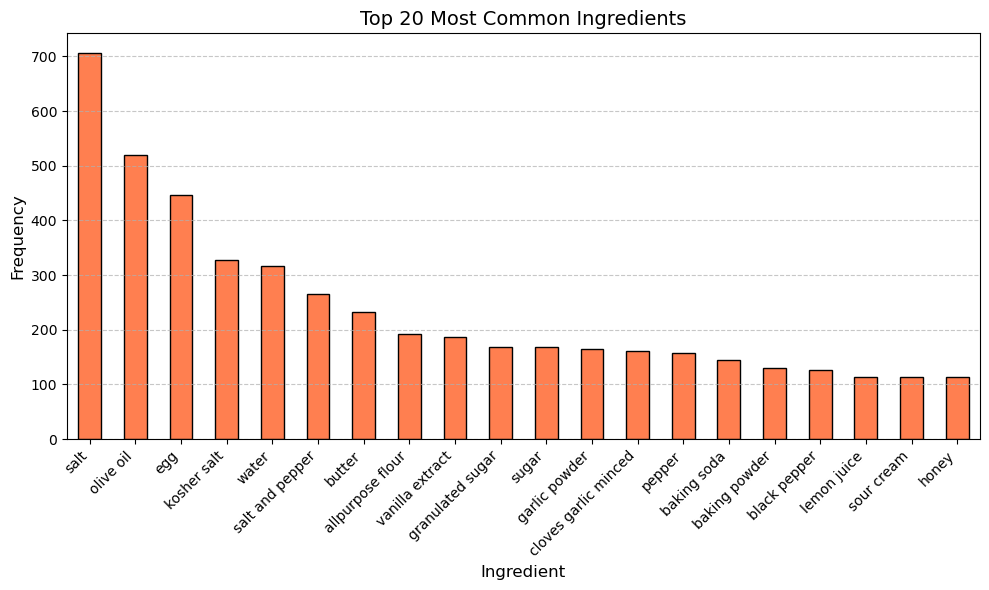

In [ ]:
# Plot the top 20 most common ingredients
plt.figure(figsize=(10, 6))
ingredient_freq.nlargest(20).plot(kind='bar', color='coral', edgecolor='black')

plt.title('Top 20 Most Common Ingredients', fontsize=14)
plt.xlabel('Ingredient', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### Distribution of Ingredient Counts and Instruction Length

This distribution of respectively Ingredient Counts and Instruction Length, helps reveal whether most recipes are simple or more elaborate. Understanding the ingredient count and instruction length are useful for both filtering and personalization—users may prefer quicker recipes with fewer ingredients or be open to more complex ones depending on their cooking preferences.

#### Ingredient Counts

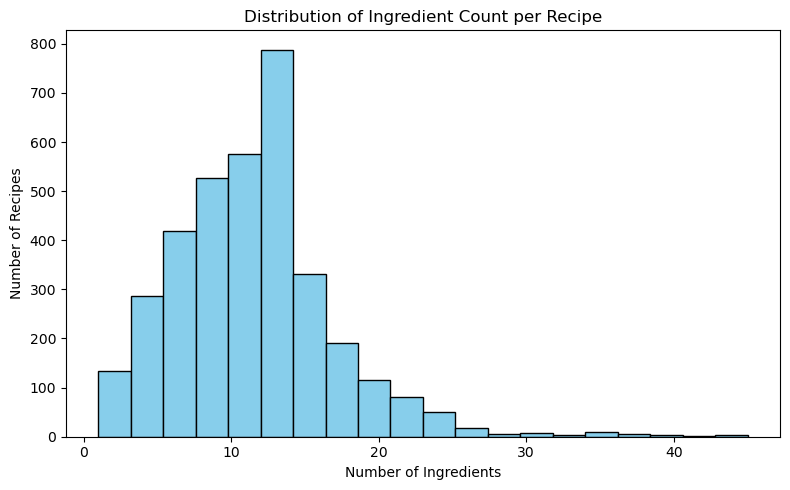

In [ ]:
# Count number of ingredients (by converting string to list first)
english_recipes_df['ingredient_count'] = english_recipes_df['Ingredients'].apply(
    lambda x: len(ast.literal_eval(x)) if pd.notnull(x) else 0
)

# Ingredient Count per Recipe
plt.figure(figsize=(8, 5))
english_recipes_df['ingredient_count'].hist(bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Ingredient Count per Recipe')
plt.xlabel('Number of Ingredients')
plt.ylabel('Number of Recipes')
plt.grid(False)
plt.tight_layout()
plt.show()

#### Instruction Lenght

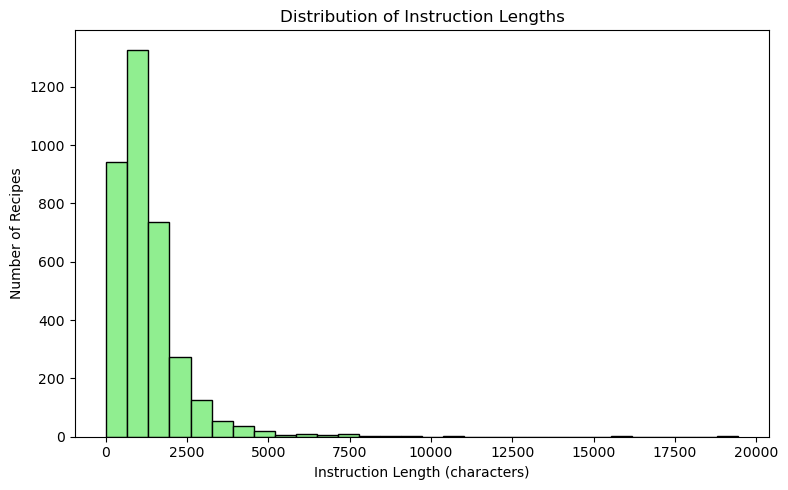

In [ ]:
# Calculate instruction length
english_recipes_df['instruction_length'] = english_recipes_df['Instructions'].str.len()

# Instruction Length
plt.figure(figsize=(8, 5))
english_recipes_df['instruction_length'].hist(bins=30, color='lightgreen', edgecolor='black')
plt.title('Distribution of Instruction Lengths')
plt.xlabel('Instruction Length (characters)')
plt.ylabel('Number of Recipes')
plt.grid(False)
plt.tight_layout()
plt.show()




### Common Heat-Based Cooking Techniques in Recipes

Since many near-expiry ingredients are not suitable for raw consumption and should be heat-processed for food safety, we examined the cooking instructions to identify common heat-based preparation methods. By scanning the instruction text for verbs such as "bake", "boil", "grill", "fry", "roast", etc., we were able to quantify how frequently these methods occur and in how many unique recipes.

In [ ]:
# List of heat-based cooking verbs
verb_keywords = [
    'bake', 'boil', 'fry', 'grill', 'roast', 'saute', 'simmer',
    'steam', 'broil', 'sear', 'poach', 'toast', 'blanch',
    'microwave', 'reheat', 'preheat', 'char', 'braise'
]

# Count total mentions of each verb (across all instructions) ---
all_verbs = []
for text in english_recipes_df['Instructions'].dropna():
    all_verbs += re.findall(r'\b(' + '|'.join(verb_keywords) + r')\b', text.lower())

total_mentions = pd.Series(Counter(all_verbs)).sort_index()

# Count unique recipes that mention each verb at least once ---
unique_recipe_mentions = {}
for verb in verb_keywords:
    # Count how many recipes mention this verb at least once
    unique_recipe_mentions[verb] = english_recipes_df['Instructions'].str.contains(
        rf'\b{verb}\b', case=False, na=False
    ).sum()

unique_recipe_mentions = pd.Series(unique_recipe_mentions).sort_index()

# Combine both counts into one DataFrame ---
verb_stats = pd.DataFrame({
    'Total Mentions': total_mentions,
    'Recipes Using Verb': unique_recipe_mentions
}).sort_values(by='Total Mentions', ascending=False)



<Figure size 1200x600 with 0 Axes>

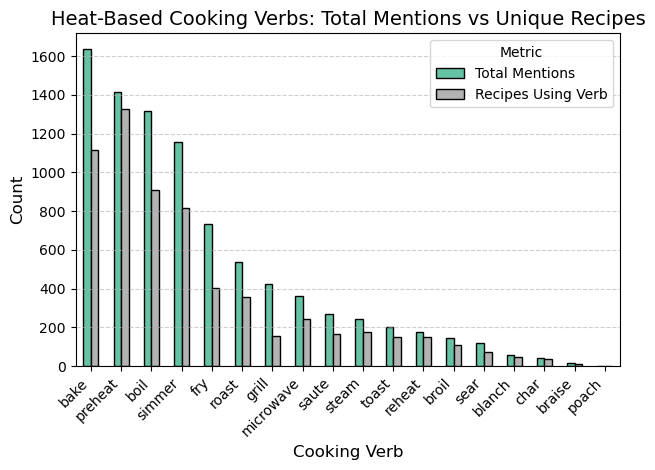

In [ ]:
# Plot a grouped bar chart
plt.figure(figsize=(12, 6))
verb_stats.plot(kind='bar', edgecolor='black', colormap='Set2')

plt.title("Heat-Based Cooking Verbs: Total Mentions vs Unique Recipes", fontsize=14)
plt.xlabel("Cooking Verb", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.legend(title="Metric")
plt.show()


In [11]:
english_recipes_df['uses_heat'] = english_recipes_df['Instructions'].str.contains(
    '|'.join(verb_keywords), case=False, na=False
)

To assess how well the dataset supports our goal of recommending recipes that are safe for using near-expiry ingredients, we analyzed the proportion of recipes that involve heat-based cooking.

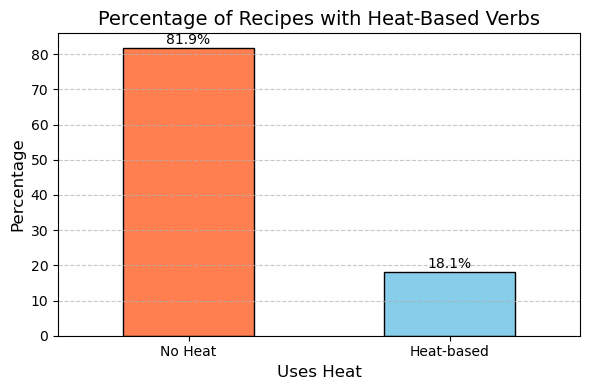

In [12]:
# Calculate percentages
heat_counts = english_recipes_df['uses_heat'].value_counts(normalize=True) * 100

# Plot the percentages with values on the bars
plt.figure(figsize=(6, 4))
bars = heat_counts.plot(kind='bar', color=['coral', 'skyblue'], edgecolor='black')
plt.title('Percentage of Recipes with Heat-Based Verbs', fontsize=14)
plt.xlabel('Uses Heat', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['No Heat', 'Heat-based'], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add percentage values on the bars
for i, value in enumerate(heat_counts):
    plt.text(i, value + 1, f'{value:.1f}%', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

This finding highlights a significant limitation in the dataset: the number of suitable recipes we can safely recommend to users is relatively small.

### Vegan/Vegetarian/Meat-Based Recipes

To support dietary personalization in the Anti-Food Waste Recommender, each recipe was classified into one of three categories: vegan, vegetarian, or meat-based. This classification was based on keyword matching within the ingredient lists. Meat-related ingredients such as "chicken", "bacon", and "tuna" flagged a recipe as meat-based, while the presence of animal-derived products like "milk", "cheese", or "honey" without meat resulted in a vegetarian label. Recipes free from both meat and animal by-products were labeled as vegan.

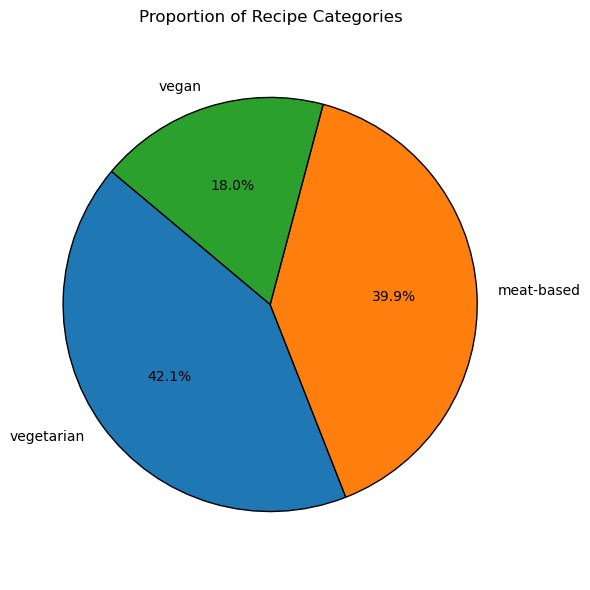

In [16]:
# Define ingredient keywords
meat_keywords = [
    "chicken", "beef", "pork", "bacon", "turkey", "sausage", "ham", "lamb", 
    "anchovy", "anchovies", "salmon", "tuna", "shrimp", "fish", "meat", 
    "prosciutto", "chorizo"
]
dairy_egg_keywords = [
    "egg", "milk", "cheese", "butter", "cream", "yogurt", "parmesan", "mozzarella"
]
non_vegan_keywords = dairy_egg_keywords + ["honey"]

# Classification function
def classify_recipe(ingredients_str):
    try:
        ingredients = ast.literal_eval(ingredients_str.lower())
    except Exception:
        ingredients = []

    has_meat = any(any(meat in ing for meat in meat_keywords) for ing in ingredients)
    has_non_vegan = any(any(item in ing for item in non_vegan_keywords) for ing in ingredients)

    if has_meat:
        return "meat-based"
    elif has_non_vegan:
        return "vegetarian"
    else:
        return "vegan"

# Apply the function to create a new column
english_recipes_df["Category"] = english_recipes_df["Ingredients"].apply(classify_recipe)

category_counts = english_recipes_df['Category'].value_counts()

# Plot the proportions as a pie chart
plt.figure(figsize=(6, 6))
plt.pie(
    category_counts,
    labels=category_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    wedgeprops={'edgecolor': 'black'}
)
plt.title('Proportion of Recipe Categories')
plt.axis('equal')  # Keeps pie chart circular
plt.tight_layout()
plt.show()


# LLM

# App

To go beyond a theoretical solution, we decided to create a functional app/website taking all the model logic so far mentioned, which allows possible users to actually interact with the system designed in a real, more tangible way. With this approach, we aim to close the gap between technical data analysis and real-world business applications, making our project both practical and impactful. The full application logic and code are contained within a single Python script (`app.py`), with clear inline comments to explain each step.

Using the Streamlit framework, we designed the app to be impactful, motivational, and informative. Therefore, to start, we added a motivational image related to food waste, helping to capture the user’s attention and set the tone. Following this, a short introductory section is provided with the title, our mission, and some bullet points that highlight the scale of food waste globally, its importance, and what our website does to help tackle it.

To ensure we can successfully match the user input ingredients with the ingredients in our database, two helper functions were created. The first, `normalize_ingredient_name`, standardizes user input by converting it to lowercase and removing plural endings where appropriate. The second function, `match_ingredient`, compares user input with database ingredients at the word level with the help of the first function, making the matching process flexible and more robust, even if users input variations of ingredient names. It is to note that, if the user inputs have spelling mistakes, the system may not find a matching recipe in our data, as it was not feasible within the current timeframe to incorporate error correction or suggestion features. Nevertheless, implementing these functionalities could be a very valuable and feasible improvement for further development of the project in the future.

Furthermore, dietary preferences (vegan and vegetarian) are collected with no default preselection (`index=None`), making sure that the users freely choose their dietary preferences. The app verifies that these fields are completed before allowing the search to proceed, with clear warnings if the inputs are missing. The users' responses are stored in boolean variables, `vegan` and `vegetarian`, which are later used to filter recipes.

Thereafter, the users arrive at the stage to input the near-expiry ingredients they have. They do so within the `🥬 Enter Ingredients` section of the app, where there is a highlighted section to be aware of spelling mistakes, plus a text box to add the aforementioned ingredients. There can be more than one item inputted at once, but they need to be comma-separated - as it is mentioned in the user input area. Once the dietary selections and ingredient(s) are provided, the users are instructed to press the "Find Recipes" button, which loads the recipe data `(recipe_df = pd.read_csv('receipts_table.csv'))`, filtering only heat-processed recipes for practicality. Matching recipes are found using the `find_heat_processed_ingredient` function, which checks that all user-provided ingredients match those in a recipe, while also respecting any dietary restrictions.

If matching recipes are found, the app displays a list of recipe titles that match the criteria inputted, followed by detailed information for each recipe, including ingredients and step-by-step instructions. Otherwise, the app shows a text warning, ensuring that the user experience remains clear and informative.

Throughout the app and its code, we make sure to integrate strong error handling and a good overall structure, separating normalization, matching, and filtering into individual functions, to ensure that the app is easy to understand and scalable.

By creating a functional app rather than just a static report, we wanted to simulate how this project could be applied in the real world. In practice, users would simply input what ingredients they have at home that are about to go bad, and immediately receive meal ideas tailored to their needs, dietary restrictions, and available food, thus minimizing waste and maximizing resource use.

# Conclusions